In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read Data
NYX = pd.read_csv("NYX2019.csv", sep = "\t", usecols = ["language","tweet"])
REVLON = pd.read_csv("REVLON2019.csv", sep = "\t", usecols = ["language","tweet"])
WETNWILD = pd.read_csv("WETNWILD2019.csv", sep = "\t", usecols = ["language","tweet"])

In [3]:
NYX = NYX[NYX["language"]=="en"]
NYX.index=range(len(NYX))

REVLON = REVLON[REVLON["language"]=="en"]
REVLON.index=range(len(REVLON))

WETNWILD = WETNWILD[WETNWILD["language"]=="en"]
WETNWILD.index=range(len(WETNWILD))

In [4]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [5]:
## Preprocessing
def textPreprocessing(text) :
    # to lower case
    text = text.lower()
    
    # delete url
    text = re.sub(r"(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]","",text)
    
    #delete all the non-English characters  
    res = re.compile("[^a-z^A-Z^0-9]")
    text = res.sub(r" ", text)
    
    # tokenize
    text = nltk.word_tokenize(text)
    # delete stopwords
    filtered = [w for w in text if w not in stopwords.words('english')]
    # only use NN
    refiltered = nltk.pos_tag(filtered)
    filtered = [w for w, pos in refiltered if pos.startswith('NN')]
    
    # Stem
    ps = PorterStemmer()
    filtered = [ps.stem(w) for w in filtered]
    
    # Lemmanisation
    lemmatizer = nltk.stem.WordNetLemmatizer()
    filtered = [lemmatizer.lemmatize(w) for w in filtered]

    return " ".join(filtered)

In [6]:
NYX_list = []
for i in range(0, len(NYX)):
    NYX_list.append(textPreprocessing(NYX["tweet"][i]))
NYX_doc = " ".join(NYX_list)

REVLON_list = []
for i in range(0, len(REVLON)):
    REVLON_list.append(textPreprocessing(REVLON["tweet"][i]))
REVLON_doc = " ".join(REVLON_list)
   
WETNWILD_list = []
for i in range(0, len(WETNWILD)):
    WETNWILD_list.append(textPreprocessing(WETNWILD["tweet"][i]))
WETNWILD_doc = " ".join(WETNWILD_list)

In [7]:
doc_list=[]
doc_list.append(NYX_doc)
doc_list.append(REVLON_doc)
doc_list.append(WETNWILD_doc)

In [8]:
# Create the Document-Word matrix
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.externals import joblib  

# API: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1500,
                                stop_words='english')

#joblib.dump(tf_vectorizer, './vectorizer_sklearn.model')
#tf_vectorizer = joblib.load('./vectorizer_sklearn.model')

tf = tf_vectorizer.fit_transform(doc_list)


#print(tf)

In [9]:
# LDA training
# API: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics,  # number of topics
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf)  # tf is Document_word Sparse Matrix

#joblib.dump(lda, './LDA_sklearn_main.model')
# lda = joblib.load('./LDA_sklearn_main.model')

#print(lda.perplexity(tf))

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

LatentDirichletAllocation(max_iter=200, verbose=True)

## The dominant topic in each document

In [10]:
lda_output = lda.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]
# index names
docnames = ["NYX","REVLON","WETNWILD"]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
NYX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6
REVLON,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7
WETNWILD,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5


In [11]:
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

In [12]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and dis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  43.288497
5       0.648955  71.707100       2        1  29.219521
7      71.019684   9.971006       3        1  27.475563
0       3.785981  33.185135       4        1   0.002346
1     -42.666500  -9.222070       5        1   0.002346
2      -3.621689 -43.526516       6        1   0.002346
3      -3.632402  -4.171708       7        1   0.002346
4     -36.584400  35.804413       8        1   0.002346
8      44.391380  50.615383       9        1   0.002346
9      40.235809 -31.591665      10        1   0.002346, topic_info=               Term      Freq       Total Category  logprob  loglift
245       colorstay  454.0000  454.000000  Default  30.0000  30.0000
363           dryer  158.0000  158.000000  Default  29.0000  29.0000
1354          trade  113.0000  113.000000  Default  28.0000  28.0000
473            forc  126.0000  126.000000  Default  27.0000  27.0000
1425         voltag   95.0000   95.000000  Default  26.0000  26.0000
...             ...       ...         ...      ...      ...      ...
968        pearlesc    0.0002    3.172089  Topic10  -7.3132   0.9886
1244       staywarm    0.0002    3.172089  Topic10  -7.3132   0.9886
1252  stpatricksday    0.0002    3.172089  Topic10  -7.3132   0.9886
1317          teeth    0.0002    3.172089  Topic10  -7.3132   0.9886
1371          trunk    0.0002    3.172089  Topic10  -7.3132   0.9886

[525 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         2  0.315484   abuja
2         3  0.630969   abuja
14        2  0.315484   agenc
14        3  0.630969   agenc
36        2  0.315484   anjha
...     ...       ...     ...
1474      3  0.989283    wrap
1475      2  0.315484  wrinkl
1475      3  0.630969  wrinkl
1484      1  0.111681    yang
1484      2  0.893446    yang

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 1, 2, 3, 4, 5, 9, 10])

## The Topic’s keywords

In [13]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_)

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,abercrombiefitch,abhfam,abuja,access,acid,acn,add,adoptdontshop,adrenalin,advertis,...,yoga,youniquemakeup,youniquepresent,ytcreator,yummi,zero,zoevabrush,zoevacosmet,zpalett,zulu
Topic0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
Topic4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [14]:
# Get the top 15 keywords each topic
n_top_words = 15

def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=n_top_words)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 1,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 2,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 3,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 4,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 5,radianc,illus,catsuit,ticket,catwalk,focu,birthdaybash,pacman,rebel,retail,pixibeauti,lorealcosmet,valu,break,jame
Topic 6,forc,voltag,howtobeauti,beautybay,calendar,ink,creativemakeup,crayoncas,pitch,sued,swang3002,maybellinefitmefound,barrymcosmet,kryolan,fantasymakeup
Topic 7,colorstay,dryer,trade,odd,bwcdeal,transluc,mouss,wrap,rev,sweepstak,strategi,decad,connect,revlonmakeup,enamel
Topic 8,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc
Topic 9,drunkeleph,hunt,nailpolish,massag,eyepencil,ashposhmarkley,miasecret,trunk,edward,stpatricksday,embryoliss,hampton,glamlifeguru,meijer,pearlesc


D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


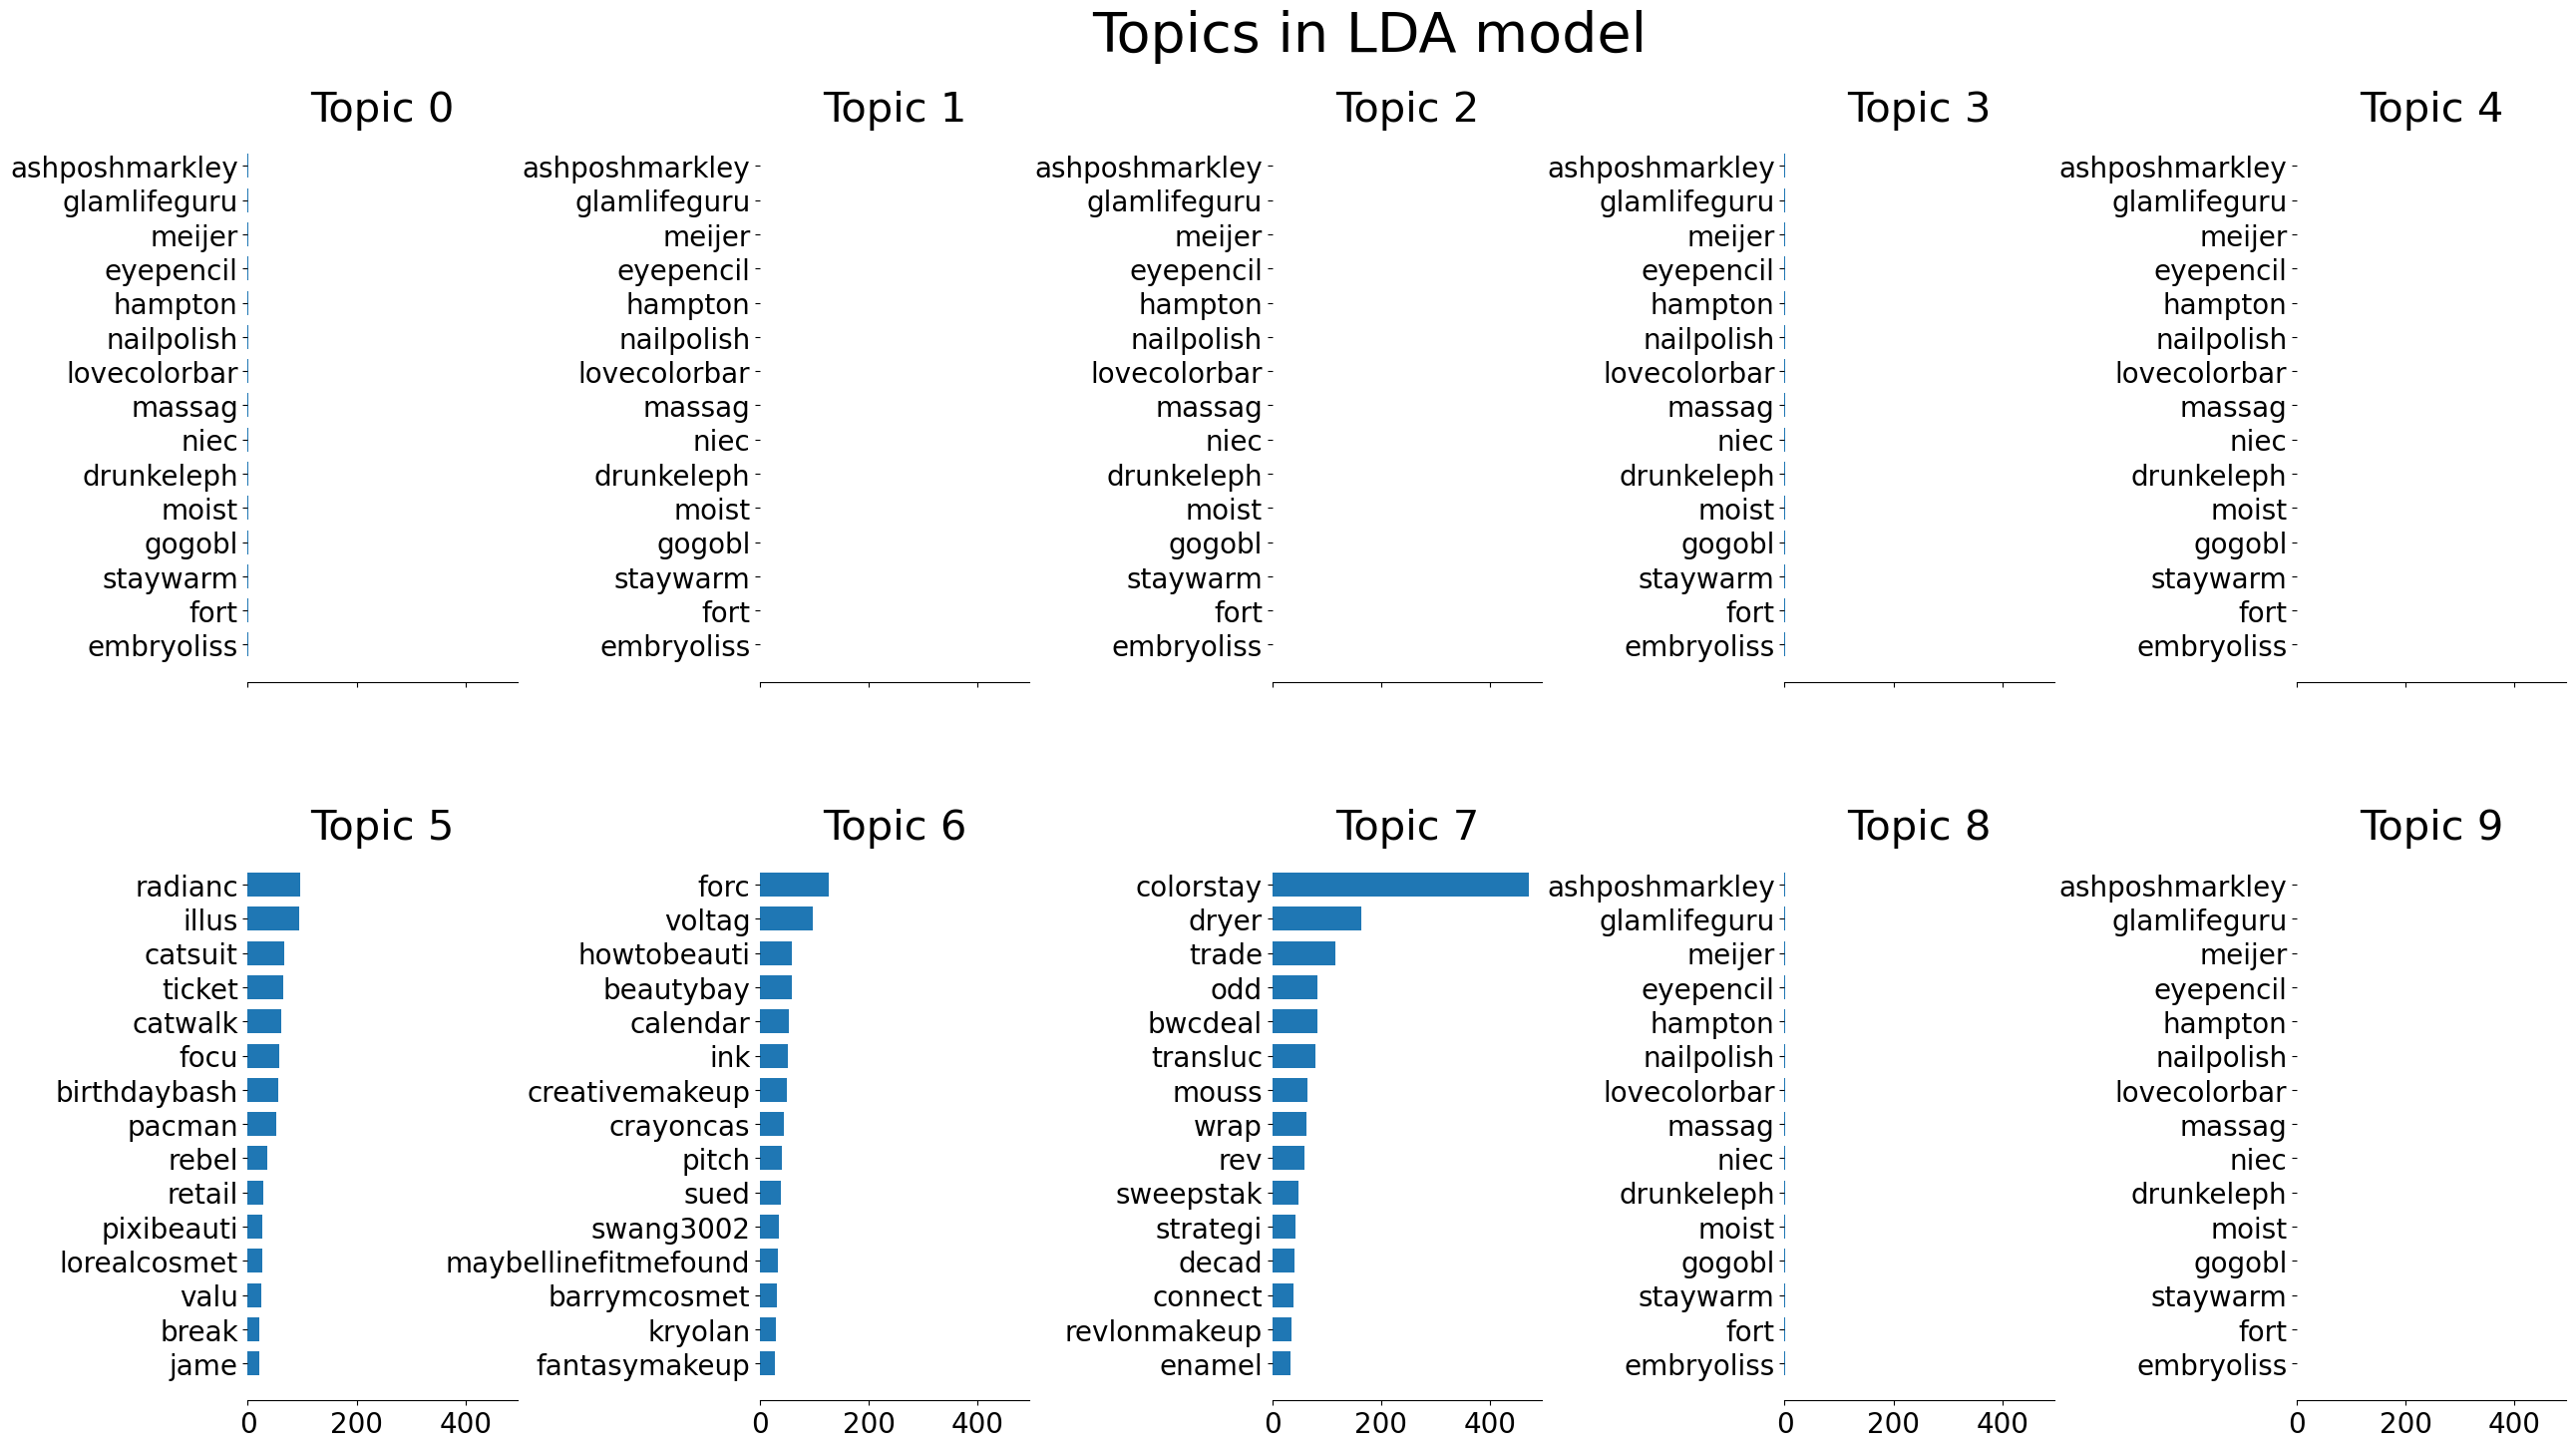

In [16]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2,5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words, 'Topics in LDA model')

In [18]:
# Single brand
tf_NYX = tf_vectorizer.fit_transform(NYX_list)

lda_Single = LatentDirichletAllocation(n_components=n_topics,  # number of topics
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda_NYX_model = lda_Single.fit(tf_NYX)
lda_NYX_output = lda_NYX_model.transform(tf_NYX)

# column names
topicnames_LDA = ["Topic" + str(i) for i in range(n_topics)]
# index names
docnames_LDA = ["Doc" + str(i) for i in range(len(NYX_list))]

# Make the pandas dataframe
df_document_topic_NYX = pd.DataFrame(np.round(lda_NYX_output, 2), columns=topicnames_LDA, index=docnames_LDA)

# Get dominant topic for each document
dominant_topic_NYX = np.argmax(df_document_topic_NYX.values, axis=1)
df_document_topic_NYX['dominant_topic'] = dominant_topic_NYX


# Apply Style
df_document_topics_NYX = df_document_topic_NYX.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics_NYX

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.290000,0.620000,0.010000,0.010000,0.010000,0.010000,5
Doc1,0.230000,0.670000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
Doc2,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,6
Doc3,0.010000,0.010000,0.150000,0.010000,0.800000,0.010000,0.010000,0.010000,0.010000,0.010000,4
Doc4,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.440000,0.400000,0.020000,7
Doc5,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.930000,0.010000,0.010000,7
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.940000,0.010000,0.010000,0.010000,0.010000,5
Doc7,0.010000,0.200000,0.010000,0.010000,0.010000,0.010000,0.720000,0.010000,0.010000,0.010000,6
Doc8,0.010000,0.010000,0.010000,0.160000,0.180000,0.570000,0.010000,0.010000,0.010000,0.010000,5
Doc9,0.220000,0.010000,0.010000,0.100000,0.010000,0.010000,0.010000,0.010000,0.620000,0.010000,8


In [19]:
panel_NYX = pyLDAvis.sklearn.prepare(lda_NYX_model, tf_NYX, tf_vectorizer, mds='tsne')
panel_NYX

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and dis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  13.958094
8       0.648955  71.707100       2        1  13.213169
9      71.019684   9.971006       3        1  12.679853
2       3.785981  33.185135       4        1  11.548763
1     -42.666500  -9.222070       5        1  11.130519
0      -3.621689 -43.526516       6        1  10.685623
5      -3.632402  -4.171708       7        1   8.425610
6     -36.584400  35.804413       8        1   7.418643
3      44.391380  50.615383       9        1   6.215032
7      40.235809 -31.591665      10        1   4.724694, topic_info=         Term         Freq        Total Category  logprob  loglift
465   fashion  1017.000000  1017.000000  Default  30.0000  30.0000
1299    style   968.000000   968.000000  Default  29.0000  29.0000
1205    share   941.000000   941.000000  Default  28.0000  28.0000
244     check   776.000000   776.000000  Default  27.0000  27.0000
657      item   921.000000   921.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
858      meet     9.902786    16.756141  Topic10  -5.5526   2.5264
1174     sand     7.851799    12.611792  Topic10  -5.7847   2.5785
513      game    22.556661    60.732915  Topic10  -4.7294   2.0619
1113  qualiti     7.201798    15.596292  Topic10  -5.8711   2.2797
960       nyx    10.847374  2659.581035  Topic10  -5.4615  -2.4496

[534 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         1  0.400656  abhcosmet
3         5  0.197584  abhcosmet
3         6  0.395167  abhcosmet
10        3  0.956691      adida
11        8  0.974024     advent
...     ...       ...        ...
1486      2  0.763041  yesterday
1486      5  0.178043  yesterday
1486      8  0.025435  yesterday
1491      2  0.880924     youtub
1491      4  0.113668     youtub

[701 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 10, 3, 2, 1, 6, 7, 4, 8])

In [20]:
# top n topic keywords
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda_NYX_model, n_words=n_top_words)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,nyxcosmet,bhcosmet,morphebrush,foundat,makeup,wetnwildbeauti,conceal,nyx,milanicosmet,revlon,palett,jamescharl,abhcosmet,ramdeno,morph
Topic 1,makeup,anastasiabeverlyhil,maccosmet,jeffreestar,nyx,jeffreestarcosmet,nyxcosmet,morph,lash,benefitcosmet,mua,girl,benefit,essenc,juviasplac
Topic 2,makeup,nyx,mua,beauti,makeupartist,fentybeauti,glam,makeupaddict,nyxcosmet,glitter,morph,mac,look,juviasplac,makeuplov
Topic 3,maccosmet,nyx,beauti,makeupforeverhd,kapoorneeta,mumbaiphotograph,mumbaimua,warfram,howtobeauti,nyxupd,goddess,art,muaindia,pc,pencil
Topic 4,makeup,lip,nyx,nyxcosmet,palett,matt,lipstick,liner,cream,cosmet,color,liquid,eye,beauti,gloss
Topic 5,check,ebay,nyx,lot,cosmet,onsal,voltag,lippi,oz,makeup,powder,eye,snowstorm,shadowstick,neon
Topic 6,nyx,nyxcosmet,cosmet,day,collect,life,katvondbeauti,drugstoremakeup,influenst,eyelin,katvond,beauti,faceart,urbandecaycosmet,makeup
Topic 7,night,power,home,creation,fantasi,origin,fantasyart,forc,ancient,insight,darrienia,hour,cryptocurr,crypto,game
Topic 8,makeup,nyx,look,beauti,palett,youtub,morph,today,video,love,maybellin,mua,eyeshadow,contour,mascara
Topic 9,fashion,style,share,item,poshmarkapp,poshmark,nyx,shopmycloset,swang3002,coach,studio,michaelkor,express,jcrew,forever21


D:\ProgramData\Anaconda3\envs\cs760\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


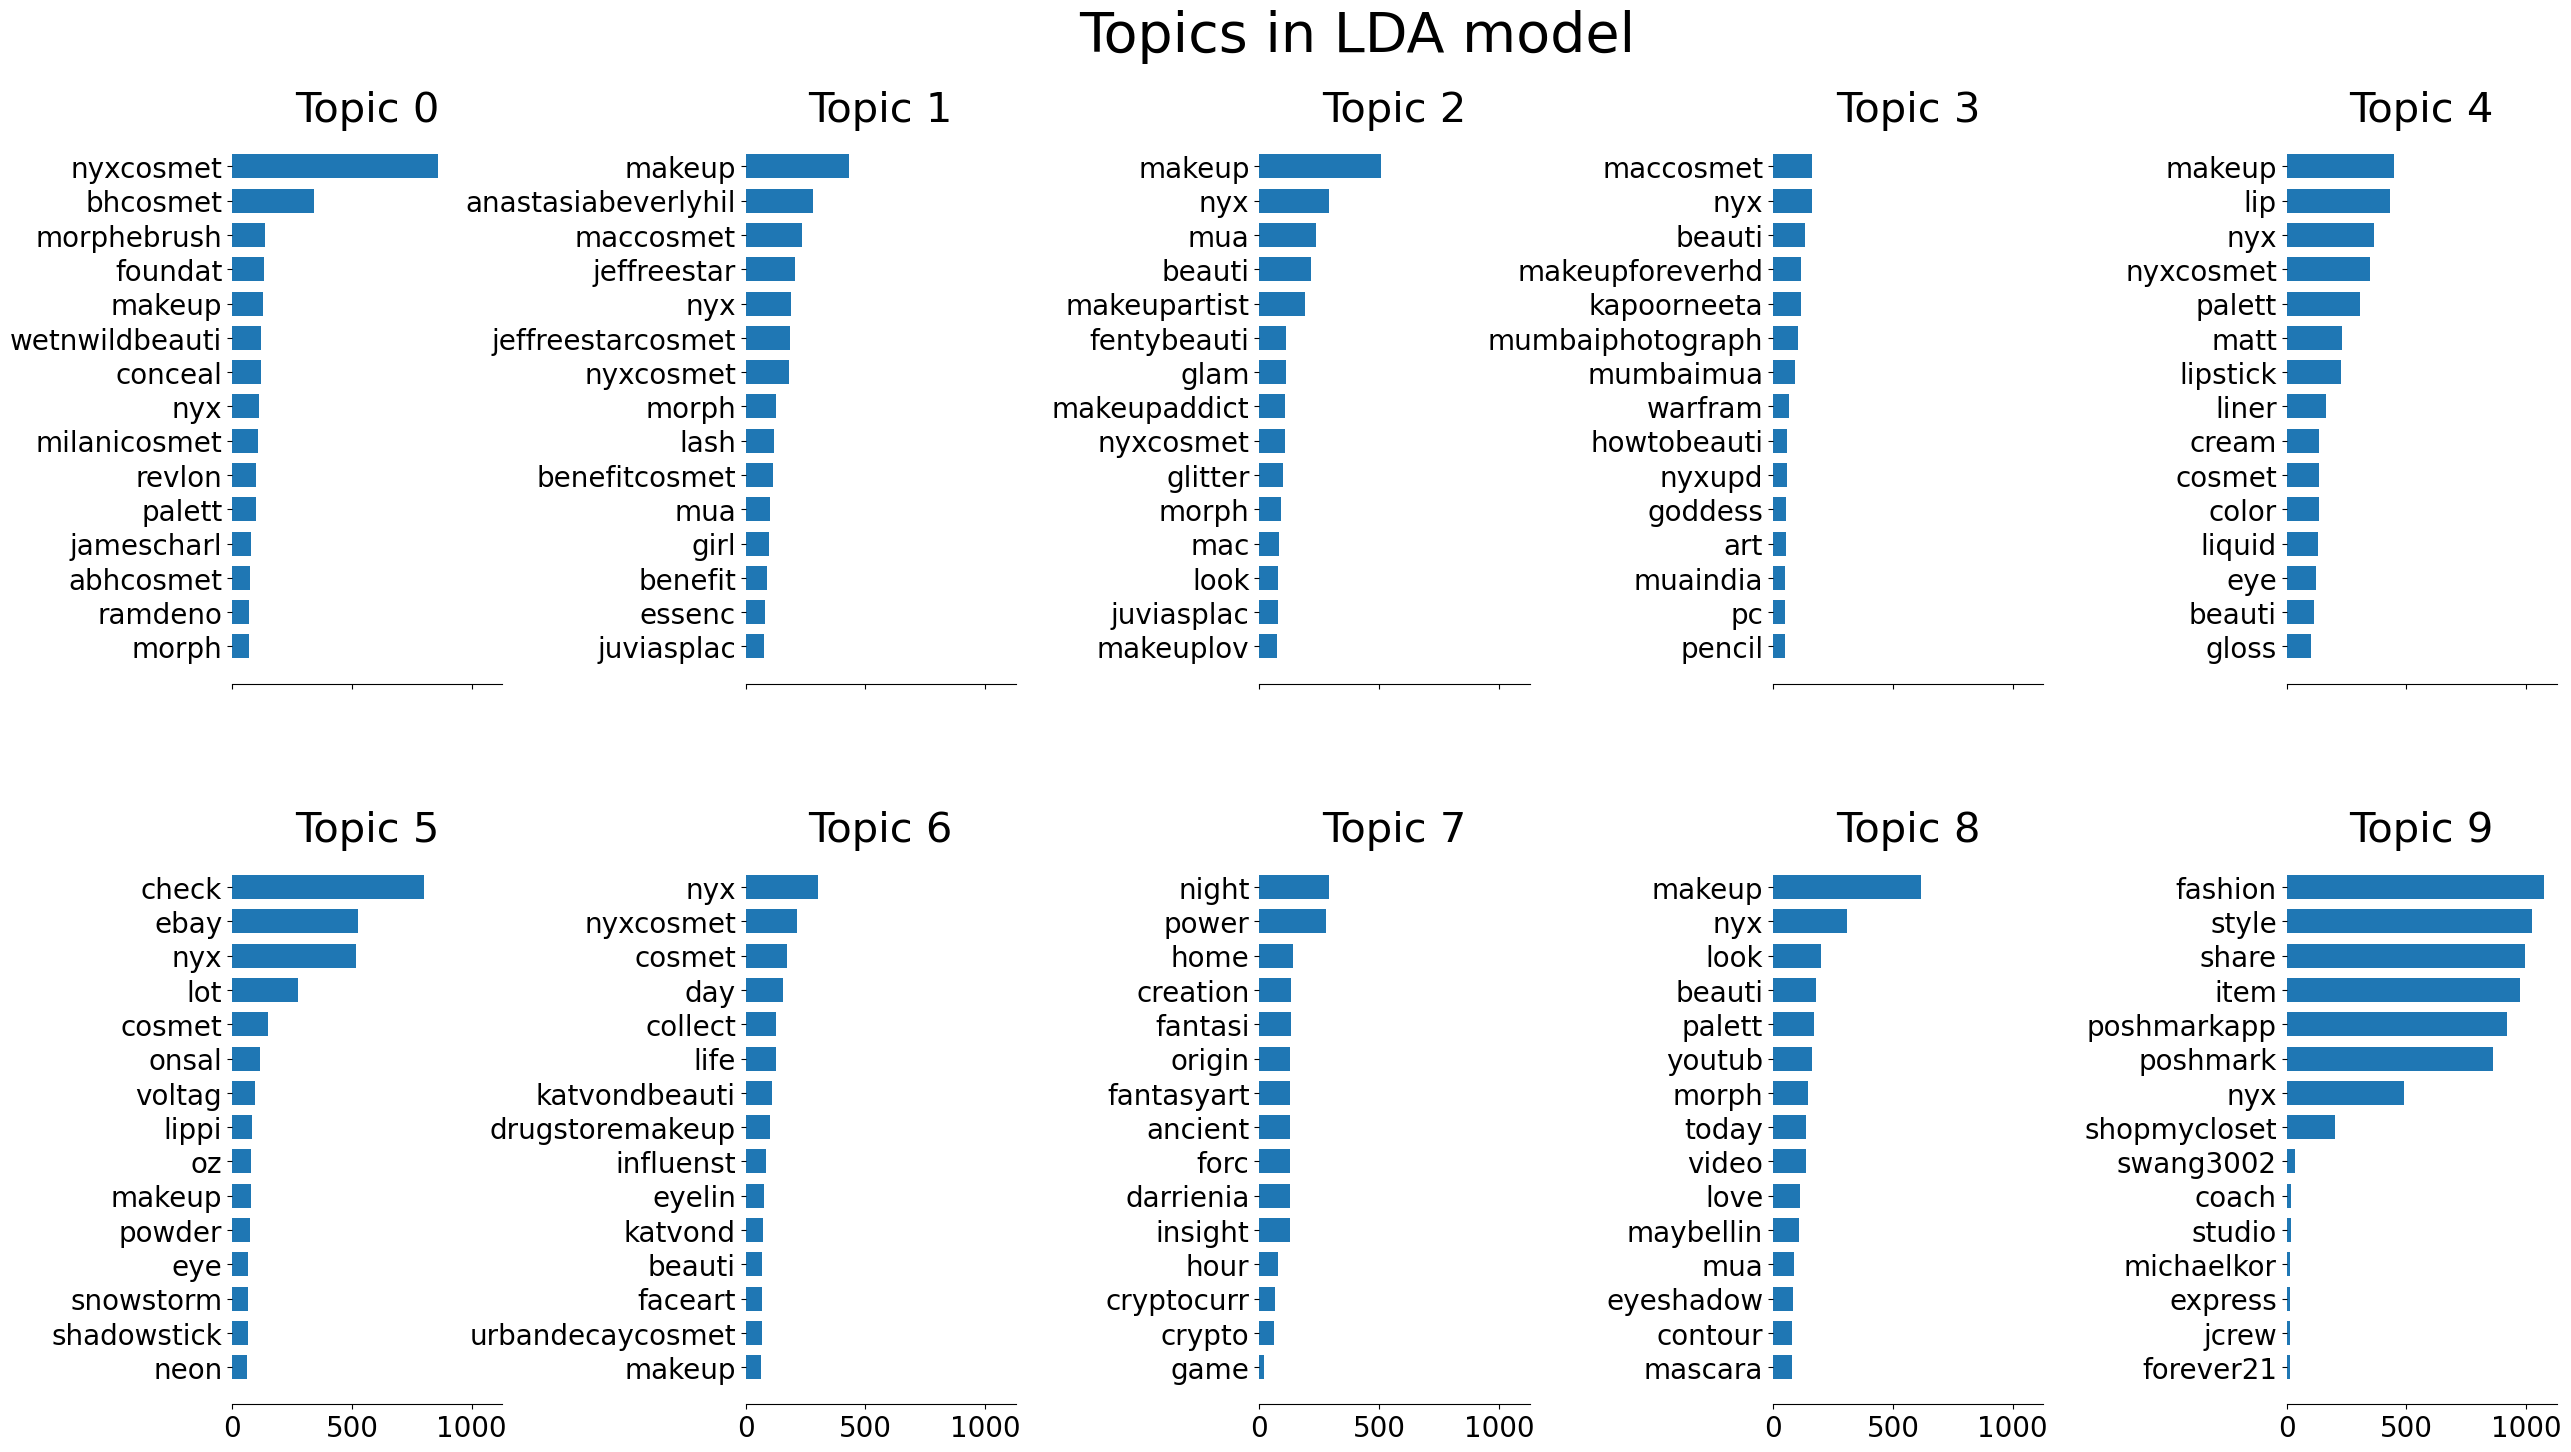

In [21]:
plot_top_words(lda_NYX_model, tf_vectorizer.get_feature_names(), n_top_words, 'Topics in LDA model')